In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf

from time import time
import datetime

import embedding_generator as emb
import data_pipeline as pipe

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt 

# Additional settings

In [2]:
OXFORD_PATH = os.path.join('..','data','oxbuild_images_zipped','oxbuild_images')
PARIS_PATH = os.path.join('..','data','paris_zipped','paris')

PARIS_EMBEDS = os.path.join('..','outputs','paris_embed')
OXFORD_EMBEDS = os.path.join('..','outputs','oxford_embed')

WHICH_DATASET = 'oxford' # 'oxford' or 'paris' 

OUTPUT_PATH = '../outputs/tsne_graphs/{}'.format(WHICH_DATASET)

PCA_LEVEL = 256
ITERATIONS = 5000

OXFORD_PATH_TXT = os.path.join(OXFORD_PATH, 'gt_files_170407')
PARIS_PATH_TXT = os.path.join(PARIS_PATH, 'paris_120310')

PARIS_LABELS = ['defense','eiffel','invalides','louvre','moulinrouge','museedorsay','notredame','pantheon','pompidou','sacrecoeur','triomphe']
OXFORD_LABELS = ['all_souls','ashmolean','balliol','bodleian','christ_church','cornmarket','hertford','keble','magdalen','pitt_rivers','radcliffe_camera']

NUMBER_OF_LABELS = 11 # keep this as the same as the number of types of labels in the set. Both paris and oxford have 11 different types
IMAGES_PER_LABEL = 5

blacklist = ["paris_louvre_000136.jpg",
            "paris_louvre_000146.jpg",
            "paris_moulinrouge_000422.jpg",
            "paris_museedorsay_001059.jpg",
            "paris_notredame_000188.jpg",
            "paris_pantheon_000284.jpg",
            "paris_pantheon_000960.jpg",
            "paris_pantheon_000974.jpg",
            "paris_pompidou_000195.jpg",
            "paris_pompidou_000196.jpg",
            "paris_pompidou_000201.jpg",
            "paris_pompidou_000467.jpg",
            "paris_pompidou_000640.jpg",
            "paris_sacrecoeur_000299.jpg",
            "paris_sacrecoeur_000330.jpg",
            "paris_sacrecoeur_000353.jpg",
            "paris_triomphe_000662.jpg",
            "paris_triomphe_000833.jpg",
            "paris_triomphe_000863.jpg",
            "paris_triomphe_000867.jpg",]

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [3]:
if WHICH_DATASET == 'paris':
    label_list = PARIS_LABELS    
    labels_dictionary, junk_dictionary = emb.images_with_labels(PARIS_PATH_TXT, PARIS_LABELS)
    path2txt = PARIS_PATH_TXT
    embed_path = PARIS_EMBEDS
elif WHICH_DATASET == 'oxford':
    label_list = OXFORD_LABELS    
    labels_dictionary, junk_dictionary = emb.images_with_labels(OXFORD_PATH_TXT, OXFORD_LABELS)
    path2txt = OXFORD_PATH_TXT
    embed_path = OXFORD_EMBEDS
else:
    raise ValueError('WHICH_DATASET has an invalid string.')

# Apply PCA

In [4]:
def apply_pca(output_dim, embedding_path, whitening = True):
    PCA_obj = PCA(output_dim, whiten = whitening)
    
    big_list = []
    name_list = []

    for dirname, _, filenames in os.walk(embedding_path):
        for filename in filenames:
            npy_path = os.path.join(dirname, filename)
            embedding = np.load(npy_path)
            big_list.append(embedding)
            filename = filename.replace('.npy','.jpg')
            name_list.append(filename)

    big_list = tf.convert_to_tensor(big_list)
    result = PCA_obj.fit_transform(big_list)
    result = tf.convert_to_tensor(result)
    
    return result, name_list

In [5]:
def images_with_labels_for_tsne(path2txt, label_list, filetype='jpg'):
    path2txt = path2txt#.decode()
    
    rev_label_dict = {}
    
    for i in range(len(label_list)):
        label = label_list[i]#.decode()
        
        query_name = label+'_1'

        query = query_name+'_query.txt'
        good = query_name+'_good.txt'
        ok = query_name+'_ok.txt'
        junk = query_name+'_junk.txt'

        ### get the query image path from the _query.txt
        with open(os.path.join(path2txt,query)) as file:
            contents = file.read().split(' ') 
            query_image_name = contents[0].replace('oxc1_','')+"."+filetype #remove the oxc1_ part which exists in the oxford query txt

        list_of_good = pipe.generate_img_list(path2txt, good)
        list_of_ok = pipe.generate_img_list(path2txt, ok)
        list_of_junk = pipe.generate_img_list(path2txt, junk)

        tmp_list = list_of_good + list_of_ok
        
        for img_name in tmp_list:
            rev_label_dict[img_name] = i
        
    return rev_label_dict

In [6]:
def create_label_list_for_tsne(name_list, rev_label_dict):
    label_list = []
    for i in name_list:
        try:
            label_list.append(rev_label_dict[i])
        except:
            label_list.append(11)
    return label_list

# Perform t-SNE

In [7]:
# Perform pca
result, name_list = apply_pca(PCA_LEVEL,embed_path,whitening=False)

# Get labels, and delete junk images
reverse_dictionary = images_with_labels_for_tsne(path2txt, label_list)
label_index_list = np.asarray(create_label_list_for_tsne(name_list, reverse_dictionary))
junk_indices = np.where(label_index_list == 11) 
label_index_list_2 = np.delete(label_index_list, junk_indices, 0)
result_2 = np.delete(np.asarray(result), junk_indices, 0)

# perform TSNE
tsne = TSNE(verbose=1, n_iter=ITERATIONS)
tsne_results = tsne.fit_transform(result_2)
x = np.asarray(tsne_results[:, 0])
y = np.asarray(tsne_results[:, 1])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 567 samples in 0.007s...
[t-SNE] Computed neighbors for 567 samples in 0.159s...
[t-SNE] Computed conditional probabilities for sample 567 / 567
[t-SNE] Mean sigma: 0.155628
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.710999
[t-SNE] KL divergence after 1950 iterations: 0.629036


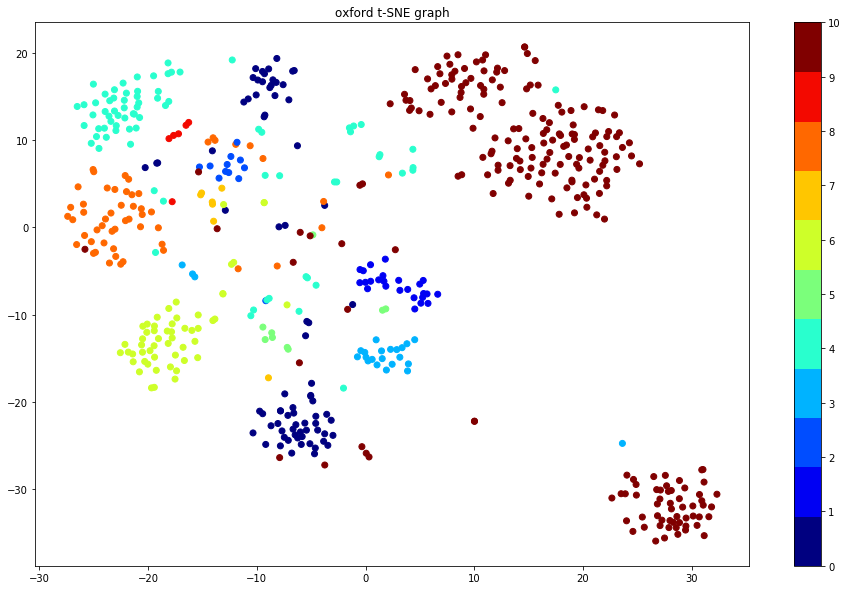

In [8]:
# plot
plt.figure(figsize=(16,10))
plt.scatter(x, y, c=label_index_list_2, cmap=plt.cm.get_cmap("jet", len(label_list)))
plt.colorbar(ticks=range(len(label_list)))
plt.title('{} t-SNE graph'.format(WHICH_DATASET))
plt.savefig('{}/{}_{}_{}'.format(OUTPUT_PATH,current_time,PCA_LEVEL,ITERATIONS))
plt.show()